# Particle Swarm Optimization for Calibration in Spatially Explicit Agent-Based Modeling

**Authors:** [Alexander Michels](https://scholar.google.com/citations?user=EbmZrwYAAAAJ), [Jeon-Young Kang](https://scholar.google.com/citations?user=u5cevWAAAAAJ), [Shaowen Wang](https://scholar.google.com/citations?user=qcUhJIcAAAAJ)

Special thanks to [Zhiyu Li](https://scholar.google.com/citations?user=yskFOAgAAAAJ) and [Rebecca Vandewalle](https://scholar.google.com/citations?user=1WzQbAgAAAAJ) for suggestions and feedback on this notebook!

![Gif of Particle Swarm Optimization](../img/movie.gif)

This notebook is related to an upcoming publication entitled "Particle Swarm Optimization for Calibration in Spatially Explicit Agent-Based Modeling." The abstract for the paper is:

>A challenge in computational modeling of complex geospatial systems is the amount of time and resources required to tune a set of parameters that reproduces the observed patterns of phenomena of being modeled. Well-tuned parameters are necessary for models to reproduce real-world multi-scale space-time patterns, but calibration is often computationally-intensive and time-consuming. Particle Swarm Optimization (PSO) is a swarm intelligence optimization algorithm that has found wide use for complex optimization including non-convex and noisy problems. In this study, we propose to use PSO for calibrating parameters in spatially explicit agent-based models (ABMs). We use a spatially explicit ABM of influenza transmission based in Miami, Florida, USA as a case study. Further, we demonstrate that a standard implementation of PSO can be used out-of-the-box to successfully calibrate models and out-performs Monte Carlo in terms of optimization and efficiency.

Particle Swarm Optimization (PSO) was first introduced in [1995 by James Kennedy and Russell Eberhart](https://doi.org/10.1109/ICNN.1995.488968). The algorithm began as a simulation of social flocking behaviors like those exhibited by flocks of birds and schools of fish, specifically of birds searching a cornfield, but was found to be useful for training feedforward multilayer pernceptron neural networks. Since then, PSO has been adapted in a variety of ways and applied to problems including [wireless-sensor networks](https://doi.org/10.1109/TSMCC.2010.2054080), [classifying biological data](https://doi.org/10.1109/SIS.2005.1501608), [scheduling workflow applications in cloud computing environments](https://doi.org/10.1109/AINA.2010.31), [Image classification](https://doi.org/10.1109/ICIP.2006.312968) and [power systems](https://doi.org/10.1109/TEVC.2007.896686). In this notebook we explore PSO's usefulness for calibration, with a focus on spatially-explicit agent-based models (ABMs).

## Table of Contents

* [Why PSO?](#why)
* [Particle Class](#part-class)
    * [Velocity Determination](#part-vel)
* [The PSO Class](#pso-class)
    * [PSO Topologies](#pso-top)
* [Running It](#running)
* [Adding Your Own Model](#customize)
* [Running It on the Command Line or HPC](#running-cli)
* [Spatially-Explicit ABMs](#spatial-abm)
* [Learn More](#learn-more)

**Note: You must run the cell below to import the required packages or the rest of the notebook will not work.**
  

To run the notebook, please uncomment and run the cell below and then restart the kernel using Kernel -> Restart Kernel. You should then be able to run the notebook as normal.

In [1]:
# !pip install imageio

In [2]:
# import required packages
""" PSO class """
from PSO import *

""" Viz """
from IPython.display import Image, display, Markdown, Math
import ipywidgets
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import shutil
import warnings
%matplotlib inline
#warnings.filterwarnings('ignore')
# use the following for dark theme:
plt.style.use('dark_background')

<a id="why"> </a>

## Why Particle Swarm Optimization (PSO)?

Model calibration is essentially an optimization problem: we want to find the parameters (which can be thought of as a location in a parameter space) which minimize or maximize some metric, often error (RMSE, MAE, etc.). A model with $n$ parameters can be thought of as an $n$-dimensional *parameter space*, which each choice of parameters represents a point in that space $\overrightarrow{x}=(x_{1},\cdots, x_{n})$. Of course we usually don't want to consider every point in $\mathbb{R}^{n}$, we usually have a set of bounds for our parameters, which we will call our feasible region $\mathcal{C}$.

So given a model $m$, we want to find the parameters $\overrightarrow{x}=(x_{1},\cdots,x_{n})$  such that $\overrightarrow{x}\in \mathcal{C}$ that minimizes the error of the model $err(m(\overrightarrow{x}))$. If we could calculate this $err(m(\overrightarrow{x}))$ for every point $\overrightarrow{x}\in\mathcal{C}$, we would get an *error surface*. Model calibration seeks to find the minimum point in this error surface. Of course, with continuous variables or computationally intensive models, it isn't possible or feasible to check every possibility, so we need to know how best to find the approximate answer without just checking every possible set of parameters (or point in the feasible reason $\mathcal{C}$).

This is relatively straight-forward some of the time, like when there is no randomness and when the error surface is convex, but in spatially-explicit agent-based modelling, those assumptions are often violated. Spatially-explicit agent-based models (SEABMs) usually incorporate some level of randomness and often have complex error surfaces which makes parameter calibration difficult. Non-convex optimization problems are known to be NP-hard and some have even been shown to be NP-hard to solve approximately! Thus to tackle this problem, we need an optimization method that works well on non-convex problems and performs well on noisey objective functions and PSO has been shown to meet both of these criteria! 

In the rest of the notebook, we will learn more about the PSO method and apply it to some non-convex and noisey functions to put it to the test! The basic idea is this: we have a set of particles which move through the our parameter space. Their "fitness" is determined by the error of the model using their position in space as parameters. The particles communicate, using their "[swarm intelligence](https://en.wikipedia.org/wiki/Swarm_intelligence)" to try to determine the best set of parameters.

<a id="part-class">
</a>

## Particle Class

Below is the code for a simple Particle that will makeup our swarm. The Particle has a few important functions:

* `__init__` - intializes the Particle object with a max velocity and bounds. The Particle picks a random point in the bounds as its initial position and generates a random velocity in $[-1,1]^N$ where $N$ is the dimension of the bounds.
* `copy_from` - copies position, velocity, and error information from another Particle object. Useful for syncing when using multi-processing.
* `evaluate` - evaluates the fitness of the Particle's position using the cost function if the Particle is in bounds. `func_sel` is a dictionary that provides information to the cost function such as particle position (`x`) and other necessary parameters. 
* `update_velocity` - uses its best position and its neighbors best position (`pos_best_g` which stands for position best global) to calculate a new velocity. This calculation uses a constriction factor and velocity clamping.


<a id="part-vel">
</a>

## Velocity Determination

![VelocityDetermination](../img/VelocityDetermination.png)

Particles use input from their environment and their neighbors to try to figure out which direction will result in better positions. 

* **Current Velocity** is the direction that the particle is currently going in.
* **Individual** is the individual particle's best position in space.
* **Social** is the best position in space seen by the particle's neighbors, defined using a neighbor graph.

The original equation (Kenedy & Eberhart 1995) was:

$$\overrightarrow{v}_{t+1} = \overrightarrow{v}_{t}+2\cdot \beta_{1} (pbest-curr) + 2\cdot \beta_{2}(gbest-curr)$$

where $\overrightarrow{v}_{i}$ is velocity at timestep $i$, $\beta_{1},\beta_{2}$ are uniform random variables [0,1], curr is the current position, pbest is the personal best position, and gbest is the global best position. The calculation means that a particle's velocity is a sum of its current velocity (momentum), cognitive/individual input, and social input. They note in their paper that "the stochastic factor was multiplied by 2 to give it a mean of 1 so that agents would "overfly" the target about half the time"

Our velocity determination is very similar, but uses a few suggested improvements. Much of our improvements come from a paper by Bratton & Kennedy ([Defining a Standard for Particle Swarm Optimization](https://doi.org/10.1109/SIS.2007.368035)). Two particularly helpful improvments described by Bratton & Kennedy are due to the work of Clerc ([The swarm and the queen: towards a deterministic and adaptive particle swarm optimization](https://doi.org/10.1109/CEC.1999.785513)) and Eberhart & Shi ([Comparing inertia weights and constriction factors in particle swarm optimization](https://doi.org/10.1109/CEC.2000.870279)) who suggested a "constriction factor" to help the algorithm converge and using maximum velocities to limit particles from shooting off away from the bounds. Using the work from these papers, the new velocity update formula is:

$$\overrightarrow{v}_{t+1}=\chi (\overrightarrow{v}_{t}+c_{1}\beta_{1}(pbest-curr)+c_{2}\beta_{2}(gbest-curr))$$

$$\chi = \frac{2}{\|2-\phi-\sqrt{\phi^{2}-4\phi}\|}, \phi=c_{1},c_{2}$$

$\chi$ above describes the constriction factor and as discussed in [Bratton & Kennedy's paper](https://doi.org/10.1109/SIS.2007.368035), $\phi=4.1$ ensures convergence, thus giving us that $c_{1},c_{2}=2.05$ and $\chi\approx0.72984$. Note that here "gbest" refers to "the best position obtained by the particle's neighbors" which can be the global best if all particles are connected, but varies based on the topology of the particle communication structure (see below).

In [3]:
# data for plotting velocity
beta_1, beta_2 = random.random(), random.random()
curr = [0,0] # current location
v_t = [4, -6] # current velocity
pbest = [-7,2] # person best location
gbest = [9,8] # global best location (according to neighbors)

Below you can explore how simple velocity determination works. The colors match the figure above so:

* Red represents the current velocity
* Blue represents the individual influence
* Green represents the social influence
* Orange is the new velocity

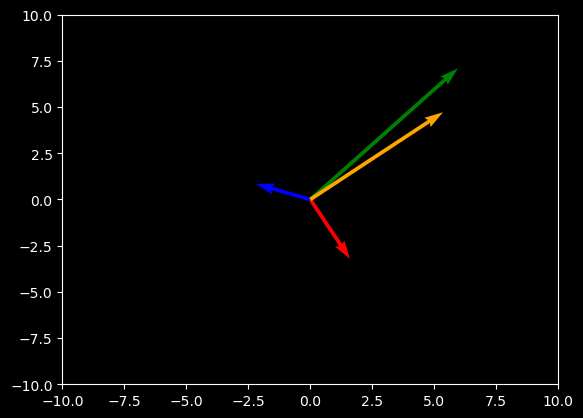

In [4]:
# plot velocity determination
# basic (no constriction factor) velocity determination
origin = np.array([[curr[0]]*4,[curr[1]]*4]) # current location
individual = 2*beta_1*np.subtract(pbest, curr)
social = 2*beta_2*np.subtract(gbest, curr)
v_t1 = np.add(np.add(v_t, individual), social)
V = np.array([v_t, individual, social, v_t1])

plt.xlim([-10,10])
plt.ylim([-10,10])
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g','orange'],scale=50)
plt.show()

Below you can see the effect of using the constriction factor.

<IPython.core.display.Math object>

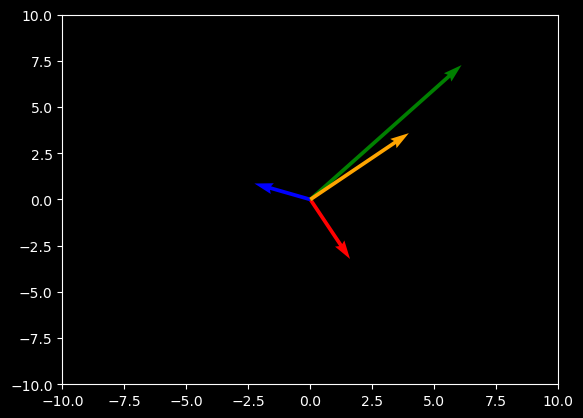

In [5]:
# plot velocity determination
# using constriction factor
c1 = 2.05        # cognitive constant
c2 = 2.05        # social constant
phi = c1 + c2
k = 2.0 / abs(2 - phi - math.sqrt(phi ** 2 - 4 * phi))
display(Math(r'c_1 = {} \\c_2 = {},\\ \phi = {}\\ \chi = {}'.format(c1,c2,phi,k)))

origin = np.array([[curr[0]]*4,[curr[1]]*4]) # current location
individual = c1*beta_1*np.subtract(pbest, curr)
social = c2*beta_2*np.subtract(gbest, curr)
v_t1 = k*np.add(np.add(v_t, individual), social)
V = np.array([v_t, individual, social, v_t1])

plt.xlim([-10,10])
plt.ylim([-10,10])
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g','orange'],scale=50)
plt.show()

*The vectors above look the same, so what's the difference?*

As mentioned above, the constriction factor comes from work by [Eberhart & Shi](https://doi.org/10.1109/CEC.2000.870279) which found that "the best approach to use with particle swarm optimization as a 'rule of thumb' is to utilize the constriction factor approach". It is meant to slightly scale down the new velocity. This is useful because it ensures that the particles will converge on a single solution.

<a id="pso-class"> </a>

## The PSO Class

The class looks long and complicated, but rest assured, much of the code is dealing with PSO parameters and logging the results out. The functions are:

* `__init__` - Initializes a swarm and calls the other necessary functions for PSO. It takes in a cost function (`costFunc`), bounds (`bounds`) and an argument dictionary which is used for PSO parameters such as whether or not to make a gif.
* `set_neighbor_graph` - sets a neighbor graph for the Particles. Neighbors communicate about most fit positions.
* `optimize` - the optimization loop. Until we reach a given number of generations/iterations, the optimize loop
* `generate_gif` - generate a gif of the run. This also means that the surface will be plotted at each step which is not feasible for computationally intensive functions like ABMs.
* `plot_surface` - plots the surface with the history of the particles. Again note that this is not feasible for computationally intensive functions.
* `plot_surface_this_timestep` - used if `gif==True` to produce a snapshot of the surface with the particle position and movement at eash timestep. These snapshots are compiled into a gif at the end of the run

<a id="pso-top">
</a>


## PSO Topology

![PSO Topologies](../img/PSOTopologies.png)

The topology or neighbor graph of the particle determines which particle communicate with each other. This creates the "social" component of the velocity determination function and allows the particles to cooperate when finding the best set of parameters.

The original Particle Swarm Optimization implementation relied on a "global best", but there has been extensive work to explore different communication network structures. The two most commonly explored graph structures are usually referred to as "gbest/global best" which describes a fully connected graph where each particle is connected to each other and "lbest/local best" which describes a graph where each particle is only connected to two others forming a ring. The are illustrated in the above figure on the left and right. In our implementation, they are called "fullyconnected" and "ring". 

Work has also been done to explore other topologies like random graphs, "pyramid", "star", "small world", and von Neumann based on von Neumann neighborhoods. I highly recommend the papers by Kennedy & Mendes ([Population Structure and Particle Swarm Performance](https://doi.org/10.1109/CEC.2002.1004493)) as well as Bratton & Kennedy's work ([Defining a Standard for Particle Swarm
Optimization](https://doi.org/10.1109/SIS.2007.368035)) as a starting point. Kennedy & Mendes found that von Neumann worked most consistently while more recent work by Bratton & Kennedy recommends a ring topology.

We have implemented the "gbest" (`fullyconnected`), "lbest" (`ring`) and von Neumann (`vonNeumann`) topologies.

In [6]:
# function for creating graph describing communication between particles
def set_neighbor_graph(num_particles, topology):  # add more topologies
    neighbor_graph = np.zeros((num_particles, num_particles))  # turn into numpy structure
    if topology == "fullyconnected":
        for i in range(num_particles):
            for j in range(num_particles):
                neighbor_graph[i, j] = 1
    elif topology == "ring":
        for i in range(num_particles):
            for j in range(num_particles):
                if j == i - 1 or j == i + 1:
                    neighbor_graph[i, j] = 1
                elif i == 0 and j == num_particles - 1:
                    neighbor_graph[i, j] = 1
                elif i == num_particles - 1 and j == 0:
                    neighbor_graph[i, j] = 1
    elif topology == "vonNeumann":
        """ https://doi.org/10.1109/CEC.2002.1004493 """
        n = num_particles
        r = math.floor(math.sqrt(n))
        for i in range(n):
            neighbor_graph[i, (i + 1) % n] = 1
            neighbor_graph[(i + 1) % n, i] = 1
            neighbor_graph[i, (i - 1) % n] = 1
            neighbor_graph[(i - 1) % n, i] = 1
            neighbor_graph[i, (i + r) % n] = 1
            neighbor_graph[(i + r) % n, i] = 1
    return neighbor_graph

In the fully connected topology, all particles talk to each other so information about where the best location might be spreads fast. This fast spread of information means that particles often converge quickly on a singular place which can be good for exploring a small area in-depth, but can mean that the particles don't adequately explore the full space.

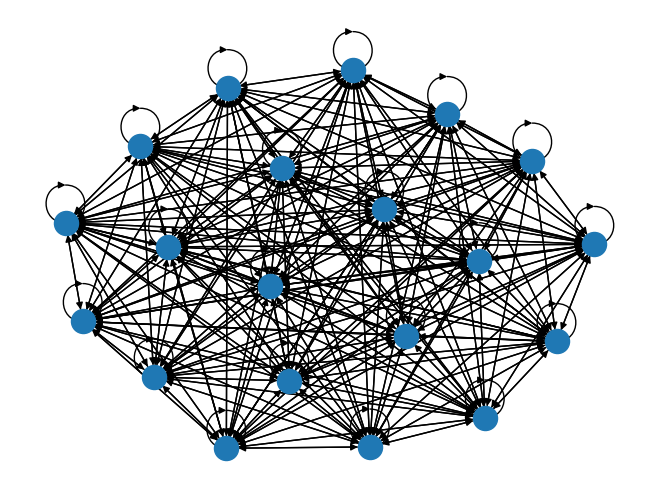

In [7]:
# fullyconnected topology
num_particles = 20
A = set_neighbor_graph(num_particles, "fullyconnected")
G = nx.from_numpy_array(A, create_using=nx.DiGraph)
nx.draw(G)

The ring topology has the particles connected in a large cycle or ring. This means that information moves very slowly through the network. Generally this means that the particles explore more of the space and take longer to converge on a single spot.

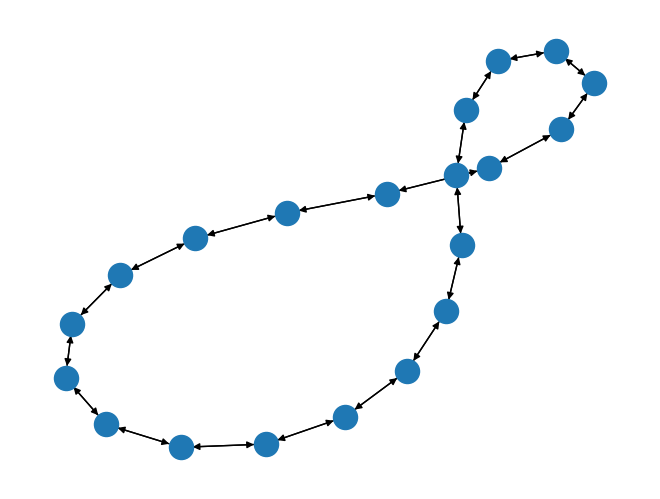

In [8]:
# ring topology
A = set_neighbor_graph(num_particles, "ring")
G = nx.from_numpy_array(A, create_using=nx.DiGraph)
nx.draw(G)

The von Neumann topology splits the difference between the "fullyconnected" and "ring" topologies. Particles are more connected than in the ring, but not quite as connected as in the fullyconnected one.

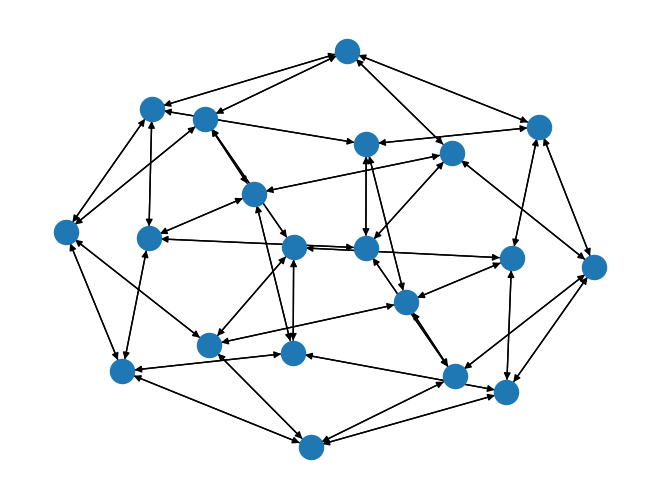

In [9]:
# vonNeumann topology
A = set_neighbor_graph(num_particles, "vonNeumann")
G = nx.from_numpy_array(A, create_using=nx.DiGraph)
nx.draw(G)

<a id="running"></a>

## Running It

Before we run the algorithm, let's discuss the full set of parameters which are passed through a JSON file (or dictionary as we will see below). There is a `test.json` file that gives sample parameters:

In [10]:
!cat test.json

{
    "function": {
        "dim_description": "None",
        "dimension": 2,
        "function": "eggholder"
    },
    "gif": "True",
    "headless": "False",
    "max_velocity": "inf",
    "metric": "rmse",
    "output_dir": "",
    "particles": 20,
    "seed": "None",
    "termination": {
        "max_iterations": 36,
        "termination_criterion": "iterations"
    },
    "threads": 1,
    "topology": "fullyconnected"
}


The parameters above mean:
    
* `function` gives information on the function to optimize.
  * `function/dim_description` can be a list of labels for the different dimensions. For example with the SEIR model we used `["introRate","reproduction","infRate"]`. If nothing is supplied, we use x\[0\],...x\[n\].
  * `function/dimension` gives the number of dimensions in the parameter space (the number of parameters).
  * `function/function` specifies the function name in text. This is used by `PSO.py`'s `main` function to determine the correct function to optimize.
  * you can also pass any other amount of information in this `function` dictionary in case your function/model needs other information! See [Adding Your Own Model](#customize) to learn more about adding your own model.
* `gif` is a boolean that specifies whether or not you want to make a gif of the algorithm run. **SET TO FALSE FOR COMPUTATIONALLY INTENSIVE FUNCTIONS OR MODEL** because it uses 40,000 evaluations per iteration to plot the error surface.
* `headless` is a boolean. `True` minimizes the amount printed to the terminal.
* `max_velocity` is used to specify the maximum velocity. See the velocity determination information above for more info.
* `output_dir` specifies the path you'd like to store outputs in, this is joined to "./outputs". So for example if you specified "test", the outputs would be stored in "./outputs/test/". This is useful for grouping together runs of the algorithm.
* `particles` gives the number of particles.
* `seed` is the seed for a random number generator. "None" uses no seed.
* `termination` allows us to specify when the algorithm should terminate.
  * `termination/termination_criterion` specifies how the PSO algorithm knows when to stop. `iterations` is the only supported option, but you're welcome to expand on this code and test others!
  * `termination/max_iterations` is necessary for the `iterations` termination criterion and gives the number of generations that PSO should go through.
* `threads` is the number of threads used by the `multiprocessing` pool.
* `topology` gives the topology of the particle communication network. See above for more info!

Below you can run PSO on a simple function! The functions below are common benchmark functions, to learn more about each function, click the link:

* [Eggholder](https://www.sfu.ca/~ssurjano/egg.html) - Non-convex
* [Michalewicz (michal)](https://www.sfu.ca/~ssurjano/michal.html) - Non-convex
* Noisey Paraboloid (this is the paraboloid function over $[-10,10]^{2}$ but with a uniform random number between (-10,10) added to the result to introduce randomness) - Noisey
* [Paraboloid/Sphere](http://benchmarkfcns.xyz/benchmarkfcns/spherefcn.html) - Convex
* [Rastrigin](http://benchmarkfcns.xyz/benchmarkfcns/rastriginfcn.html) - Non-convex
* [Shubert](http://benchmarkfcns.xyz/benchmarkfcns/shubertfcn.html) - Non-convex

To add more functions like those [seen on Wikipedia](https://en.wikipedia.org/wiki/Test_functions_for_optimization) and [this site](http://benchmarkfcns.xyz/fcns).

**Note: You may not get the true minimum value from PSO, that is normal and not a bug. With the exception of the paraboloid, these are non-convex functions which are hard to optimize.**

In [11]:
# create dropdowns for algorithm parameters
# feel free to adjust the values on the sliders/dropdowns!
func_dropdown = ipywidgets.Dropdown(
    options=get_standard_funcs(),
    description = "Cost Func",
    value=noisey_paraboloid
)
generations_slider = ipywidgets.IntSlider(
    value=36,
    min=1,
    max=120,
    step=1,
    description="N Generations"
)
part_slider = ipywidgets.IntSlider(
    value=20,
    min=1,
    max=100,
    step=1,
    description='N Particles'
)
topology_dropdown = ipywidgets.Dropdown(
    options=[ "fullyconnected", "ring", "vonNeumann" ],
    description="Topology",
    value="ring"
)
display(func_dropdown,generations_slider,part_slider,topology_dropdown)

Dropdown(description='Cost Func', index=2, options=(('eggholder', <function eggholder at 0x7fe1223dd5e0>), ('m…

IntSlider(value=36, description='N Generations', max=120, min=1)

IntSlider(value=20, description='N Particles', min=1)

Dropdown(description='Topology', index=1, options=('fullyconnected', 'ring', 'vonNeumann'), value='ring')

In [12]:
# pass the arguments into the PSO function and run it
args = {
    "gif" : "True",
    "headless" : "False",
    "max_velocity" : "inf",
    "metric" : "rmse",
    "output_dir" : "",
    "particles" : part_slider.value,
    "seed" : "None",
    "threads" : 1,
    "topology" : topology_dropdown.value,
    "termination": {
         "termination_criterion" : "iterations",
         "max_iterations" : generations_slider.value
    },
    "function": {
        "dim_description" : "None",
        "dimension" : 2,
        "function" : func_dropdown.value.__name__
    }
}

pprint(args)
swarm = PSO(func_dropdown.value, get_bounds(func_dropdown.value,2), args)
print("True min is {} at {}".format(*get_global_minima(swarm.costFunc, 2)))

print("\nThe results can found at the run's output directory: {}".format(swarm.output_path))
print("\nThe log for the run can be found at {}. Here is small preview:".format(swarm.log_file))
with open(swarm.log_file) as myfile:
    for i in range(3):
        print(next(myfile))

{
    "function": {
        "dim_description": "None",
        "dimension": 2,
        "function": "noisey_paraboloid"
    },
    "gif": "True",
    "headless": "False",
    "max_velocity": "inf",
    "metric": "rmse",
    "output_dir": "",
    "particles": 20,
    "seed": "None",
    "termination": {
        "max_iterations": 36,
        "termination_criterion": "iterations"
    },
    "threads": 1,
    "topology": "ring"
}
|-----+-------------------+-----------------------------------------
| Gen | Global Best Error | Global Best Pos 
|-----+-------------------+-----------------------------------------
| 0   | inf               | [] 
| 1   |          7.422129 | [-3.170050650913126, 2.6113489809184802] 
| 2   |          6.431661 | [-2.6273806675282474, -1.2380737156800006] 
| 3   |         -2.182604 | [-0.08283240421236293, -0.45663197498223784] 
| 4   |         -2.182604 | [-0.08283240421236293, -0.45663197498223784] 
| 5   |         -2.182604 | [-0.08283240421236293, -0.456631974982

<Figure size 1200x1000 with 0 Axes>

#### What am I looking at here?

**Above:**

* The first output above is the parameters we are passing into the PSO function.
* Next, you should see a table that describes the generation of the algorithm the global best error (lowest error encountered by any particle), and the position that produced the error.
* At the end of the table, you will see the word "FINAL" which gives the best position and minimum error achieved over the run of the algorithm.
* Next, the output director is printed in case you want to explore the results yourself.
* Lastly, we print out the location of the log file along with the first 3 lines of it, in case you want to explore that.

**Below:**

* The next cell below plots the neighbor graph of the particles using Networkx.
* Secondly, we load the CSV result and show you the head of it so you can see what the results look like.
* Third, we show the surface and particles over the run of the algorithm. 

In [13]:
# plot the neighbor graph
G = nx.from_numpy_array(swarm.neighbor_graph, create_using=nx.DiGraph)
nx.draw(G)

This is the CSV file that holds information on the position and error of each particle throughout the run.

In [14]:
# showing the result CSV created
result_csv = pd.read_csv(swarm.csv_out.name)
result_csv.head()

Iteration  Particle 0's x[0] Position  Particle 0's x[1] Position  \
0          0                   -8.961668                   -3.634723   
1          1                   -3.198339                   -3.999527   
2          2                    1.459058                   -4.929648   
3          3                    2.705193                   -5.428567   
4          4                    0.876951                   -4.838224   

   Particle 0's Error  Particle 1's x[0] Position  Particle 1's x[1] Position  \
0          101.676445                   -2.211363                   -4.659971   
1           21.838749                   -5.406190                    2.373006   
2           29.628911                   -5.900859                   -1.532692   
3           27.735583                   -6.019037                   -5.896693   
4           20.790281                   -4.922954                   -8.821516   

   Particle 1's Error  Particle 2's x[0] Position  Particle 2's x[1] Position  \
0           24.639646                   -9.588884                    1.979263   
1           37.093091                   -9.061419                    4.383098   
2           41.151612                   -7.953218                    4.481421   
3           62.460680                   -4.725182                    3.766810   
4          109.536240                   -1.462887                    3.104691   

   Particle 2's Error  ...  Particle 17's x[0] Position  \
0           94.414055  ...                    -7.155620   
1          103.049405  ...                     2.361374   
2           90.359533  ...                    12.834077   
3           43.782873  ...                    16.804227   
4           17.848392  ...                     8.866397   

   Particle 17's x[1] Position  Particle 17's Error  \
0                     0.761629            46.626041   
1                    -0.042788            11.118772   
2                    -3.951912                  inf   
3                    -3.669847                  inf   
4                     0.987189            85.916339   

   Particle 18's x[0] Position  Particle 18's x[1] Position  \
0                    -9.948092                     2.160646   
1                    -6.859717                     0.610262   
2                     6.141978                    -1.307812   
3                    14.634908                    -2.477169   
4                     4.191403                     0.282684   

   Particle 18's Error  Particle 19's x[0] Position  \
0           100.781475                     8.215640   
1            57.211548                   -10.046476   
2            38.514452                   -18.358653   
3                  inf                   -14.170301   
4            16.100145                     3.295027   

   Particle 19's x[1] Position  Particle 19's Error  Average Error  
0                    -1.053243            70.237601      64.840798  
1                     3.525322                  inf            inf  
2                     3.394229                  inf            inf  
3                    -5.261744                  inf            inf  
4                    -9.770447           106.772042            inf  

[5 rows x 62 columns]

Here is plot of the surface, with arrows representing the particles flying around the space.

* The surface is colored based on the error at the position. This is done by evaluating 40,000 points in the space (controlled by the `granularity` argument of `plot_surface`). Obviously this is only useful for illustrative purposes and not at all feasible for computationally intensive models.
* The black dots with the yellow halo represents the initial positons of the particles.
* The yellow dots represent all of the positions evaluated by PSO.
* The arrows are colored to help distinguish particles and show how a particle has travelled throughout the run of the algorithm.

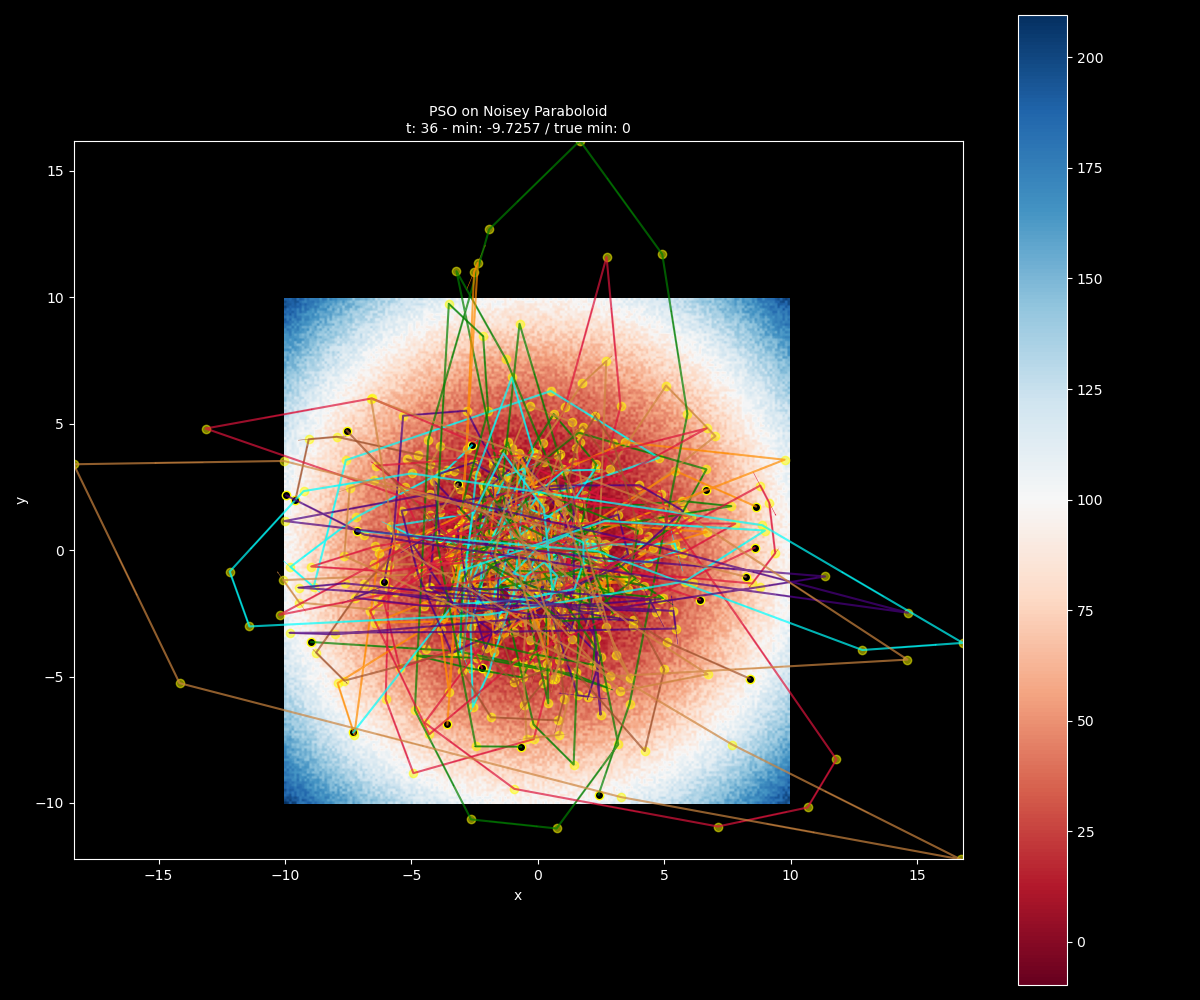

In [15]:
# plot the surface of the function with particles
Image(filename=os.path.join(swarm.output_path, "surface.png"))

Below you can see a gif of the particles moving around your space! Just as in above, the surface is colored based on error, the black dots represent initial positions, the yellow dots represent positions evaluated, and arrows show the velocity of particles through space. This is created by plotting the state of the algorithm at each interation and compiling the images together into a gif using `imageio`.

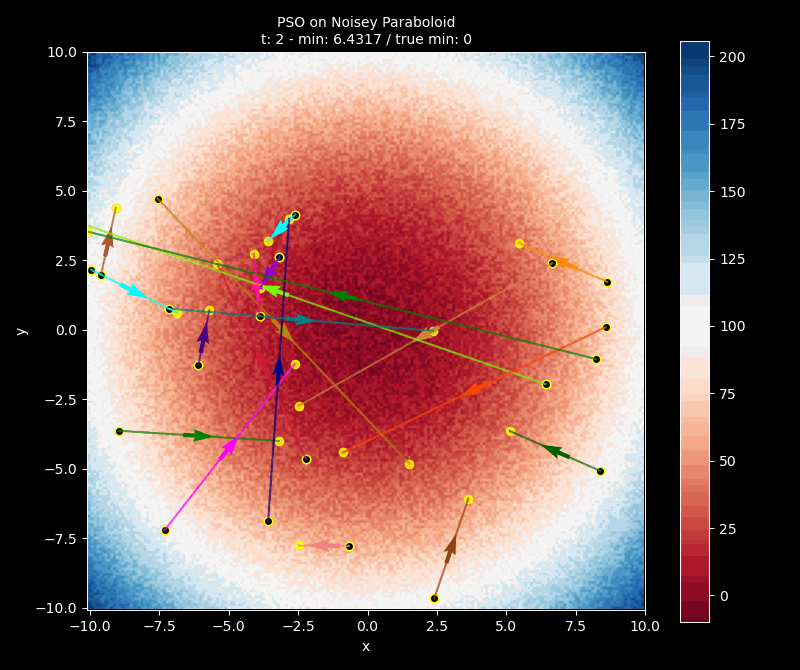

In [16]:
# plot the gif created by the algorithm
Image(filename=os.path.join(swarm.output_path, "movie.gif"))

<a id="customize"> </a>

## Adding Your Own Model

### Adding a Simple Function

Adding models/functions is relatively simple. Everything is controlled by `cost_funcs/info.py`. This file imports all of the cost functions, defines the bounds of each function, the name, and keeps track of the global minima (if known). To add your own simple function you'd like to test here, you can follow these steps:

1. Add your function in `cost_funcs/standard.py`. There are many other examples in the `cost_funcs/standard.py` file if you get confused, but here are the basic steps:

  * Each function takes the argument `args` which is a dictionary and the position vector is stored in `args["x"]`. This allows us to pass other information to the function if necessary. 
  * Every function is assumed to return a tuple with the first element being the value of the function at `args["x"]` and the second element exists in case you want to pass other information out of the function, but for a simple function just return `None`. 
  * To see that function in the dropdown above, you will also want to add the function to the `funcs` list in `get_standard_funcs()` at the bottom of the file.
2. Add the information in `cost_funcs/info.py`. This file defines three basic functions that give information on functions:
  * `get_bounds` which returns the bounds for a function. This is a list of tuples of the form [($\min x_{1}, \max x_{1}),\cdots, (\min x_{n}, \max x_{n}$)].
  * `get_function_name` which returns a string that is the name of the function. This name is used in plotting.
  * `get_global_minima` which returns a tuple (`global min`, `tuple position of global min`). This information is only used to plot the global min and its location at the end of the PSO run so you can compare. If this is not known, you can return (`any int`, `None`).
  
### Adding a More Complex Model

Now that you know how to add a basic function, we can discuss a bit about how to add a more complex model. This is how I evaluate the ABM when using PSO. Rather than defining it in `cost_funcs/standard.py` you can put the model in its own python file and copy that file to the `cost_funcs` folder. The ABM can be seen in `cost_funcs/JeonModelSimple.py`. Somewhere in the file, define the function in the same format as above: it should take a dictionary as the input with `input["x"]` containing the parameters. This can be seen in the `kang_simple` function at the bottom of `cost_funcs/JeonModelSimple.py`.

Next, import the model into `cost_funcs/info.py` and define the bounds, name, and minima as discussed above. To run PSO on your model, you can just name the function under `function/function` in the JSON parameters and also add your function to the `main` function in the PSO. There are many examples in the `main` function on how to do this, but basically you are adding an if statement that checks the name of the function supplied in the JSON file and passes the correct function to the PSO class. I highly recommend running the model on HPC if it is computationally intensive.

<a id="running-cli"> </a>

# Running from the Command Line/HPC

The code works from the command line if you specify the path to the params JSON. This is how it was used on cyberinfrastructure to evalue the spatially-explicit agent-based model. If you want to edit the parameters, simply edit the `test.json` file or create a new json file and specify that after the `--params` flag.

In [17]:
!python3 PSO.py --params test.json

...loading parameters from test.json...
{
    "function": {
        "dim_description": "None",
        "dimension": 2,
        "function": "eggholder"
    },
    "gif": "True",
    "headless": "False",
    "max_velocity": "inf",
    "metric": "rmse",
    "output_dir": "",
    "particles": 20,
    "seed": "None",
    "termination": {
        "max_iterations": 36,
        "termination_criterion": "iterations"
    },
    "threads": 1,
    "topology": "fullyconnected"
}
Swarming with 20 particles on 1 threads using iterations termination criterion with inf vmax
|-----+-------------------+-----------------------------------------
| Gen | Global Best Error | Global Best Pos 
|-----+-------------------+-----------------------------------------
| 0   | inf               | [] 
| 1   |       -724.544344 | [506.9479165486516, 413.2767061409694] 
| 2   |       -737.890036 | [507.04863383630624, 412.94257648652723] 
| 3   |       -747.410772 | [507.1221417230581, 412.6987140338031] 
| 4   |       -

### How do I use this on HPC?

Using PSO for spatially-explicit ABMs, I wasn't able to to do that on my laptop and had to use HPC, this work took months of work on a large multi-node cluster! See the [Adding Your Own Model](#customize) section if you'd like to use PSO on your own model. Assuming you have this repo cloned on your HPC, a sample BATCH file might look like:

```
#SBATCH -n 12
#SBATCH --time=240:00:00
#SBATCH --mem-per-cpu=600
#SBATCH --mail-type=FAIL
#SBATCH --mail-type=END
#SBATCH --mail-user=<your email>

module purge
module use <module path>
module load anaconda3
python3 swarm.py --params ${PARAM} -s ${SEED}
```

Of course, you may need to change this based on file locations, the number of processors you want to use, the memory requirements of your model, etc. If you want to run the algorithm for a variety of parameters/seeds, you can use a bash script like the one below to submit a set of jobs:

```
PARAMS=( "test1.json" "test2.json" )
for PARAM in "${PARAMS[@]}"; do
    for SEED in $(seq 0 4); do
        export SEED
        export PARAM
        sbatch PSO.batch
        echo "Job ${PARAM}, ${SEED} submitted"
    	sleep 5 # pause to be kind to the scheduler
    done
done
```

Again, the script above is an example, you will likely have to make some changes to get it to work for you.

<a id="spatial-abm">
</a>

## Spatially Explicit ABMs

![Map of influenza cases](../img/InfluenzaCases.png)

Our interest in PSO is for calibrating spatially-explicit agent-based models (ABMs). In particular, we chose a model [of influenza transmission developed by Jeon-Young Kang](https://doi.org/10.1145/3356470.3365531). A notebook for this model is [available on CyberGISX as well if you'd like to explore the model more indepth](https://cybergisxhub.cigi.illinois.edu/notebook/a-reproducible-and-replicable-spatially-explicit-agent-based-model-using-cybergis-jupyter-a-case-study-in-queen-anne-neighborhood-seattle-wa/). The notebook uses data from the Queene Anne neighborhood of Seattle, but this repository contains data for a Miami if you'd like to run the model for Miami.

Calibrating spatially-explicit ABMs often depend on the concept of [pattern-oriented validation](https://search.proquest.com/openview/9b2d012f5aa1a575a945ddf0f364e11b/1?pq-origsite=gscholar&cbl=18750&diss=y). Pattern-Oriented Validation is based on Pattern-Oriented Modeling (POM) which seeks to replicate observed patterns using simulation. In the case of the influenza model, the pattern is the curve describing the number of cases over a flu season and we calibrate by getting the simulated curve as close as possible to this line. For our model, we were able to obtain influenza case data from the Florida Department of Health to validate.

![Influenza cases over time](../img/InfectionCases.png)

An example JSON to run the PSO algorithm using the SEIR model can be found in `seir_test.json`:

**NOTE: The spatially explicit ABM can take 30-120 minutes per run meaning that a single generation with 20 particles can take 10-40 hours *per generation*. It is not recommended to do this on here, but rather on cyberinfrastructure with a large number of threads to speed this up.**

In [ ]:
!cat seir_test.json

The `function` dictionary here shows how you can pass information to the cost function. In the example above, we are telling the `kang_simple` SEIR function to use data for the city of Miami and run the model for 154 days. This also shows you can use the `dim_description` option to label the parameters being swarmed on.

<a id="learn-more">
</a>

# Learn More!

## PSO

#### Overview / Introductory Papers

* [Defining a Standard for PSO](https://doi.org/10.1109/SIS.2007.368035)
* [Particle swarm optimization](https://doi.org/10.1109/ICNN.1995.488968)
* [Particle swarm optimization: developments, applications and resources](https://doi.org/10.1109/CEC.2001.934374)
* [Particle Swarm Optimization: An Overview](https://doi.org/10.1007/s11721-007-0002-0)

#### Selected Applications

* [A hybrid particle swarm/ant colony algorithm for the classification of hierarchical biological data](https://doi.org/10.1109/SIS.2005.1501608)
* [A particle swarm optimization-based heuristic for scheduling workflow applications in cloud computing environments](https://doi.org/10.1109/AINA.2010.31)
* [Image classification using chaotic particle swarm optimization](https://doi.org/10.1109/ICIP.2006.312968)
* [Particle swarm optimization: basic concepts, variants and applications in power systems](https://doi.org/10.1109/TEVC.2007.896686)
* [Particle swarm optimization in wireless-sensor networks: A brief survey](https://doi.org/10.1109/TSMCC.2010.2054080)

## Calibrating Spatially-Explicit ABM

* [Pattern-Oriented Validation and Sensitivity Analysis Methods for Spatially Explicit Agent-Based Models](https://search.proquest.com/openview/9b2d012f5aa1a575a945ddf0f364e11b/1?pq-origsite=gscholar&cbl=18750&diss=y)
* [Using multiple scale space-time patterns in variance-based global sensitivity analysis for spatially explicit agent-based models](https://doi.org/10.1016/j.compenvurbsys.2019.02.006)
* [Using multiple scale spatio-temporal patterns for validating spatially explicit agent-based models](https://doi.org/10.1080/13658816.2018.1535121)